# Running the simulation

Required packages:
numpy, matplotlib, seaborn, tqdm, sklearn (scikit-learn)

In [1]:
import os
os.chdir("../")

Comment out the cell below if the simulation has already been run

In [2]:
# from src.Application import Application
# Application().run()

# Plotting overview

In [3]:
from src.plotter.directory_management import *

In [4]:
cd_general_plotting_directory()

In [5]:
from src.plotter.ping_frequencies import display_frequencies_std

# display_frequencies_std()

In [6]:
return_to_start_path_from_general()

## Plotting a single simulation

In [7]:
# choose from [1.0, 1.125, 1.25, 1.375, 1.5]
distance_scale = 1.0

# choose from [0.01, 0.0257, 0.505, 0.7525, 1]
contrast_range = 1.0

In [8]:
cd_partic_plotting_directory(distance_scale, contrast_range)

### Full stimulus

In [9]:
from src.plotter.stimulus import display_full_stimulus

# display_full_stimulus()

### Stimulus patch & local contrasts

In [10]:
from src.plotter.stimulus import display_patch_plots

# display_patch_plots()

### Stimulus currents

In [11]:
from src.plotter.stimulus import display_stimulus_currents

# display_stimulus_currents()

### Relationship between frequency & current

In [12]:
from src.plotter.stimulus import display_frequency_vs_current

# display_frequency_vs_current()

### Frequency distribution among PING networks

In [13]:
from src.plotter.ping_frequencies import display_ping_frequencies

# display_ping_frequencies()

### Spikes data

In [14]:
from src.plotter.raw_data import fetch_spikes_data
from src.params.ParamsInitializer import ParamsInitializer
from src.params.NeuronTypes import NeuronTypes
from src.izhikevich_simulation.GridGeometryFactory import GridGeometryFactory
from src.izhikevich_simulation.GridGeometry import GridGeometry
from src.izhikevich_simulation.PINGNetworkNeurons import PINGNetworkNeurons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
PLOT_SIZE = 8

mpl.rcParams['lines.linewidth'] = PLOT_SIZE / 2
mpl.rcParams['axes.linewidth'] = PLOT_SIZE / 10
mpl.rcParams['axes.labelsize'] = 2 * PLOT_SIZE
mpl.rcParams['axes.labelpad'] = 2 * PLOT_SIZE
mpl.rcParams['axes.titlesize'] = 3 * PLOT_SIZE
mpl.rcParams['axes.titlepad'] = PLOT_SIZE#2 * PLOT_SIZE
mpl.rcParams['legend.fontsize'] = 3 * PLOT_SIZE
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Avenir'
mpl.rcParams['font.weight'] = 'ultralight'

# getting parameters
params_initializer = ParamsInitializer()
params_ping, params_gabor, params_rf, params_connectivity, params_izhi, params_synaptic, params_freqs = params_initializer.initialize(
    dist_scale=distance_scale,
    contrast_range=contrast_range
)

ping_networks = GridGeometryFactory().create(params_ping, np.zeros((params_ping.nr_neurons["total"], params_ping.nr_neurons["total"]))).ping_networks
def neuron_ids_of_network(ping_network):
    return ping_network.ids[NeuronTypes.EX] + ping_network.ids[NeuronTypes.IN]

def get_spikes(spikes, ind_start, ind_end):
    indices = np.argwhere(
        (spikes.T[1] >= ind_start) &
        (spikes.T[1] < ind_end)
    ).flatten()
    return spikes[indices]

def get_ex_spikes(spikes):
    return get_spikes(spikes, params_ping.neur_slice[NeuronTypes.EX].start, params_ping.neur_slice[NeuronTypes.EX].stop)

def get_in_spikes(spikes):
    return get_spikes(spikes, params_ping.neur_slice[NeuronTypes.IN].start, params_ping.neur_slice[NeuronTypes.IN].stop)


def apply_window(arr, window_start, window_end):
    arr_window_indices = np.argwhere(
        (arr.T[0] >= window_start) & 
        (arr.T[0] < window_end) 
    ).flatten()
    return arr[arr_window_indices]

    

def select_spikes_window(spikes, spikes_ex, spikes_in, window_start, window_end):
    spikes = apply_window(spikes, window_start, window_end)
    spikes_ex = apply_window(spikes_ex, window_start, window_end)
    spikes_in = apply_window(spikes_in, window_start, window_end)
    return spikes, spikes_ex, spikes_in

Computing distances between PING networks: 100%|██| 4/4 [00:00<00:00,  4.45it/s]


In [15]:
# fetching spikes
all_spikes = fetch_spikes_data()

# indices of excitatory spikes
all_spikes_ex = get_ex_spikes(all_spikes)

# indices of inhibitory spikes
all_spikes_in = get_in_spikes(all_spikes)

# fetching spikes per ping
ping_spikes = {}
ping_spikes_ex = {}
ping_spikes_in = {}

for ping_network in ping_networks:
    
    ping_spikes_mask = np.isin(
        all_spikes.T[1], neuron_ids_of_network(ping_network)
    )
    ping_spikes[ping_network.grid_location] = all_spikes[ping_spikes_mask]
    ping_spikes_ex[ping_network.grid_location] = get_ex_spikes(ping_spikes[ping_network.grid_location])
    ping_spikes_in[ping_network.grid_location] = get_in_spikes(ping_spikes[ping_network.grid_location])

In [16]:
def compute_nr_spikes(spikes):
    return len(spikes)

def compute_mean_nr_spikes_per_ts(spikes, window):
    return np.mean([np.count_nonzero(spikes.T[0] == t) for t in range(window[0], window[1])])

def compute_std_nr_spikes_per_ts(spikes, window):
    return np.std([np.count_nonzero(spikes.T[0] == t) for t in range(window[0], window[1])])

def compute_nr_neurons_spiked_count(spikes, step):
    id_counter = np.array([np.count_nonzero(spikes.T[1] == i) for i in range(params_ping.nr_neurons["total"])])
    return np.array([np.count_nonzero(id_counter == i) for i in range(step)])


In [17]:
spikes_stats = []

step = 100
windows = [(i, i + step) for i in range(0, 1000, step)]


def compute_stats(spikes, spikes_ex, spikes_in, window):
    nr_spikes = compute_nr_spikes(spikes)
    nr_spikes_ex = compute_nr_spikes(spikes_ex)
    nr_spikes_in = compute_nr_spikes(spikes_in)
    mean_nr_spikes_per_ts = compute_mean_nr_spikes_per_ts(spikes, window)
    mean_nr_spikes_ex_per_ts = compute_mean_nr_spikes_per_ts(spikes_ex, window)
    mean_nr_spikes_in_per_ts = compute_mean_nr_spikes_per_ts(spikes_in, window)
    std_nr_spikes_per_ts = compute_std_nr_spikes_per_ts(spikes, window)
    std_nr_spikes_ex_per_ts = compute_std_nr_spikes_per_ts(spikes_ex, window)
    std_nr_spikes_in_per_ts = compute_std_nr_spikes_per_ts(spikes_in, window)
    nr_neurons_spiked_count = compute_nr_neurons_spiked_count(spikes, step)
    nr_neurons_spiked_count_ex = compute_nr_neurons_spiked_count(spikes_ex, step)
    nr_neurons_spiked_count_in = compute_nr_neurons_spiked_count(spikes_in, step)
    return [
        nr_spikes, nr_spikes_ex, nr_spikes_in, 
        mean_nr_spikes_per_ts, mean_nr_spikes_ex_per_ts, mean_nr_spikes_in_per_ts,
        std_nr_spikes_per_ts, std_nr_spikes_ex_per_ts, std_nr_spikes_in_per_ts,
        nr_neurons_spiked_count, nr_neurons_spiked_count_ex, nr_neurons_spiked_count_in
    ]

cols = []
for i in range(-1, len(ping_networks)):
    imod = "" if (i == -1) else i
    new_cols = [
        f"nr_spikes{imod}", 
        f"nr_spikes_ex{imod}", 
        f"nr_spikes_in{imod}", 
        f"mean_nr_spikes_per_ts{imod}",
        f"mean_nr_spikes_ex_per_ts{imod}",
        f"mean_nr_spikes_in_per_ts{imod}",
        f"std_nr_spikes_per_ts{imod}",
        f"std_nr_spikes_ex_per_ts{imod}",
        f"std_nr_spikes_in_per_ts{imod}",
        f"nr_neurons_spiked_count{imod}",
        f"nr_neurons_spiked_count_ex{imod}",
        f"nr_neurons_spiked_count_in{imod}"
    ]
    cols = cols + new_cols

for window in windows:
    spikes, spikes_ex, spikes_in = select_spikes_window(all_spikes, all_spikes_ex, all_spikes_in, window[0], window[1])
    gen_stats = compute_stats(spikes, spikes_ex, spikes_in, window)
    
    ping_stats = []
    for ping_network in ping_networks:
        spikes, spikes_ex, spikes_in = select_spikes_window(
            ping_spikes[ping_network.grid_location],
            ping_spikes_ex[ping_network.grid_location],
            ping_spikes_in[ping_network.grid_location],
            window[0], window[1]
        )
        ping_stats = ping_stats + compute_stats(spikes, spikes_ex, spikes_in, window)

    spikes_stats.append(gen_stats + ping_stats)

spikes_df = pd.DataFrame(
    spikes_stats, 
    columns = cols,
    index = windows
)
spikes_df
    

,nr_spikes,nr_spikes_ex,nr_spikes_in,mean_nr_spikes_per_ts,mean_nr_spikes_ex_per_ts,mean_nr_spikes_in_per_ts,std_nr_spikes_per_ts,std_nr_spikes_ex_per_ts,std_nr_spikes_in_per_ts,nr_neurons_spiked_count,...,nr_spikes_in3,mean_nr_spikes_per_ts3,mean_nr_spikes_ex_per_ts3,mean_nr_spikes_in_per_ts3,std_nr_spikes_per_ts3,std_nr_spikes_ex_per_ts3,std_nr_spikes_in_per_ts3,nr_neurons_spiked_count3,nr_neurons_spiked_count_ex3,nr_neurons_spiked_count_in3
"(0, 100)",43133,32545,10588,431.33,325.45,105.88,1425.277314,1215.103933,390.251336,"[0, 0, 0, 873, 5718, 2812, 597, 0, 0, 0, 0, 0,...",...,2776,112.11,84.35,27.76,374.634112,315.652162,104.612343,"[7500, 0, 0, 82, 1401, 741, 276, 0, 0, 0, 0, 0...","[8000, 0, 0, 82, 1401, 517, 0, 0, 0, 0, 0, 0, ...","[9500, 0, 0, 0, 0, 224, 276, 0, 0, 0, 0, 0, 0,..."
"(100, 200)",37084,27874,9210,370.84,278.74,92.10,645.245980,484.893609,203.955412,"[0, 0, 4242, 751, 742, 3155, 166, 944, 0, 0, 0...",...,3448,129.95,95.47,34.48,329.337468,237.448919,122.978005,"[7500, 0, 0, 0, 453, 1547, 52, 448, 0, 0, 0, 0...","[8000, 0, 0, 0, 453, 1547, 0, 0, 0, 0, 0, 0, 0...","[9500, 0, 0, 0, 0, 0, 52, 448, 0, 0, 0, 0, 0, ..."
"(200, 300)",28376,21049,7327,283.76,210.49,73.27,409.643970,303.206151,156.624574,"[0, 1291, 2935, 2536, 2785, 251, 202, 0, 0, 0,...",...,1400,52.43,38.43,14.00,207.898593,149.600351,75.485628,"[7500, 181, 1895, 424, 0, 0, 0, 0, 0, 0, 0, 0,...","[8000, 157, 1843, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[9500, 24, 52, 424, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
"(300, 400)",35704,26734,8970,357.04,267.34,89.70,449.503903,341.955676,176.238333,"[0, 0, 1048, 3925, 3512, 1305, 210, 0, 0, 0, 0...",...,2681,105.50,78.69,26.81,282.391944,206.581011,102.355234,"[7500, 0, 0, 225, 1694, 387, 194, 0, 0, 0, 0, ...","[8000, 0, 0, 222, 1687, 91, 0, 0, 0, 0, 0, 0, ...","[9500, 0, 0, 3, 7, 296, 194, 0, 0, 0, 0, 0, 0,..."
"(400, 500)",29086,22146,6940,290.86,221.46,69.40,424.665257,325.132078,157.890215,"[0, 0, 4611, 2603, 1875, 911, 0, 0, 0, 0, 0, 0...",...,1577,66.40,50.63,15.77,213.732028,171.057514,70.751941,"[7500, 0, 986, 1388, 126, 0, 0, 0, 0, 0, 0, 0,...","[8000, 0, 937, 1063, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[9500, 0, 49, 325, 126, 0, 0, 0, 0, 0, 0, 0, 0..."
"(500, 600)",29582,22545,7037,295.82,225.45,70.37,432.448919,313.790866,170.593356,"[0, 0, 1742, 6935, 1322, 1, 0, 0, 0, 0, 0, 0, ...",...,1481,62.71,47.90,14.81,187.266137,141.187995,72.429924,"[7500, 0, 1264, 1201, 35, 0, 0, 0, 0, 0, 0, 0,...","[8000, 0, 1210, 790, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[9500, 0, 54, 411, 35, 0, 0, 0, 0, 0, 0, 0, 0,..."
"(600, 700)",25971,19632,6339,259.71,196.32,63.39,400.534350,288.818035,165.749021,"[0, 0, 4916, 4200, 881, 3, 0, 0, 0, 0, 0, 0, 0...",...,1967,79.42,59.75,19.67,246.484530,170.721667,92.485897,"[7500, 0, 65, 1931, 501, 3, 0, 0, 0, 0, 0, 0, ...","[8000, 0, 50, 1925, 25, 0, 0, 0, 0, 0, 0, 0, 0...","[9500, 0, 15, 6, 476, 3, 0, 0, 0, 0, 0, 0, 0, ..."
"(700, 800)",32857,24962,7895,328.57,249.62,78.95,460.911212,362.898189,169.950132,"[0, 0, 3146, 4309, 280, 1425, 487, 353, 0, 0, ...",...,1511,61.02,45.91,15.11,215.714486,160.081485,78.627590,"[7500, 0, 1412, 1074, 14, 0, 0, 0, 0, 0, 0, 0,...","[8000, 0, 1410, 589, 1, 0, 0, 0, 0, 0, 0, 0, 0...","[9500, 0, 2, 485, 13, 0, 0, 0, 0, 0, 0, 0, 0, ..."
"(800, 900)",36725,27650,9075,367.25,276.50,90.75,451.890349,324.630605,188.145868,"[0, 518, 1983, 1583, 3260, 1938, 264, 454, 0, ...",...,2712,104.80,77.68,27.12,262.365851,194.246590,93.381934,"[7500, 0, 1, 230, 1811, 204, 254, 0, 0, 0, 0, ...","[8000, 0, 1, 230, 1769, 0, 0, 0, 0, 0, 0, 0, 0...","[9500, 0, 0, 0, 42, 204, 254, 0, 0, 0, 0, 0, 0..."
"(900, 1000)",27356,20795,6561,273.56,207.95,65.61,476.102118,366.622514,151.974991,"[0, 1349, 4552, 1198, 1465, 1169, 265, 2, 0, 0...",...,2757,113.56,85.99,27.57,291.254470,219.137468,110.507127,"[7500, 0, 0, 1, 1411, 821, 265, 2, 0, 0, 0, 0,...","[8000, 0, 0, 1, 1399, 600, 0, 0, 0, 0, 0, 0, 0...","[9500, 0, 0, 0, 12, 221, 265, 2, 0, 0, 0, 0, 0..."


In [18]:
spikes_df.to_csv("df.csv", index=False)

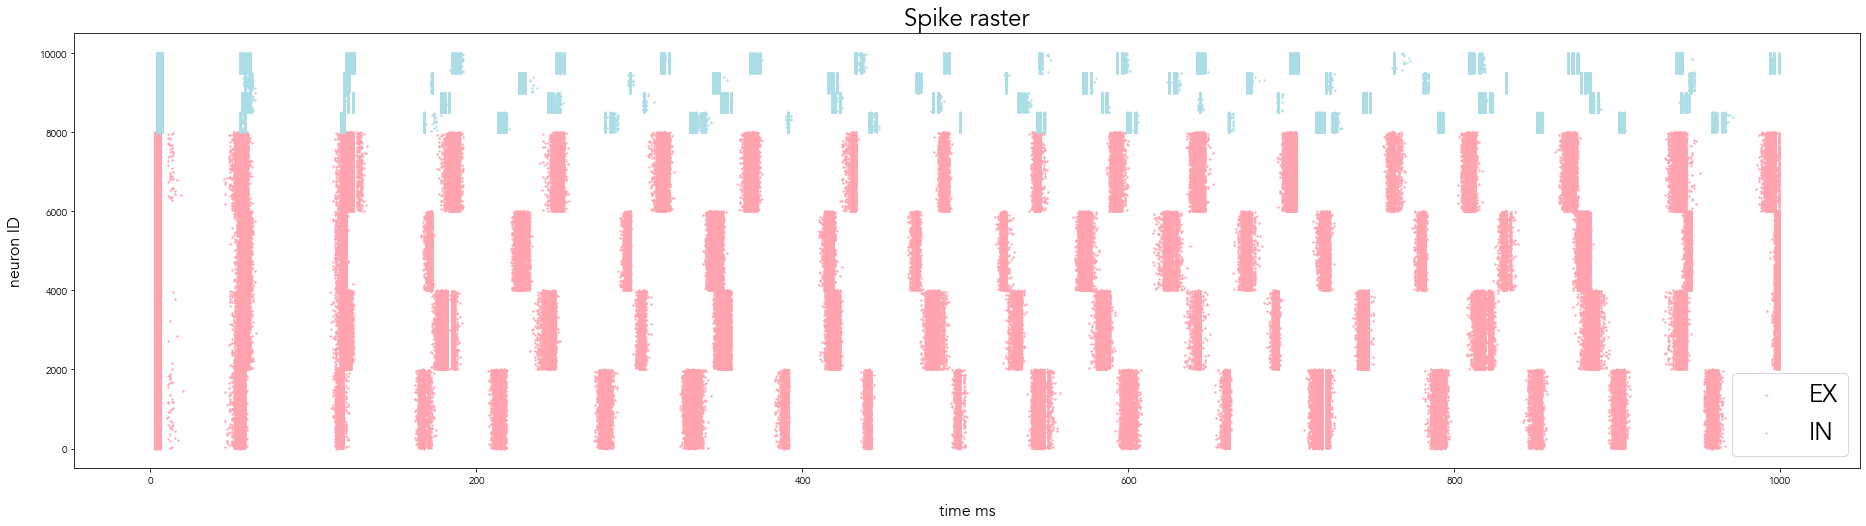

In [19]:
fig, ax = plt.subplots(figsize=(4 * PLOT_SIZE, PLOT_SIZE))

in_color = "#ACDDE7"
ex_color = "#FFA3AF"

ax.scatter(all_spikes_ex.T[0], all_spikes_ex.T[1], s=PLOT_SIZE/5, color=ex_color, label="EX")
ax.scatter(all_spikes_in.T[0], all_spikes_in.T[1], s=PLOT_SIZE/5, color=in_color, label="IN")
ax.legend()
ax.set_xlabel("time ms")
ax.set_ylabel("neuron ID")
ax.set_title("Spike raster")

fig.savefig("raster.pdf", bbox_inches='tight', pad_inches=1)

In [20]:
from collections import Counter
from statistics import mean

counter = Counter(all_spikes.T[1])
nr_spikes = counter.values()
nr_spikes
print(min(nr_spikes), max(nr_spikes), mean(nr_spikes))

24 48 32.5874


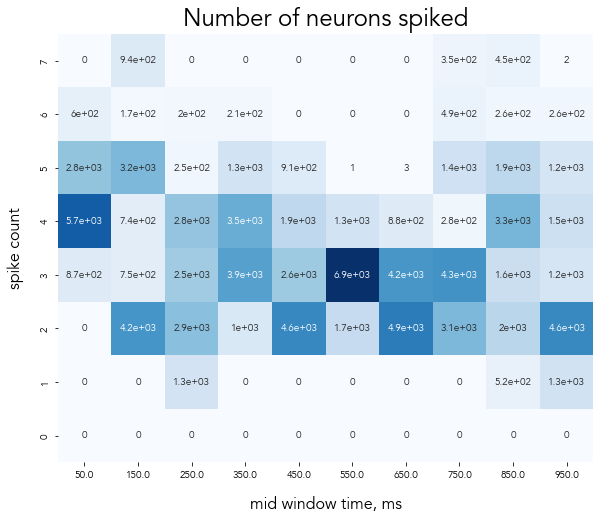

In [21]:
import seaborn as sns

mid_windows = [w[0] + (w[1] - w[0]) / 2 for w in windows]

fig, ax = plt.subplots(figsize=(1.2*PLOT_SIZE, 1.2*PLOT_SIZE))

heatmap = np.array([np.array(a) for a in spikes_df["nr_neurons_spiked_count"].to_numpy()]).T
top_nonzero = np.max(np.nonzero(heatmap)[0]) + 1

sns.heatmap(
    heatmap[:top_nonzero, :],
    annot=True,
    cbar=False,
    square=True,
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
    ax=ax
)
ax.set_xticklabels(mid_windows)
ax.set_xlabel("mid window time, ms")
ax.set_ylabel("spike count")
ax.set_title("Number of neurons spiked")
ax.invert_yaxis()

fig.savefig("nr_neurons.pdf", bbox_inches='tight', pad_inches=1)

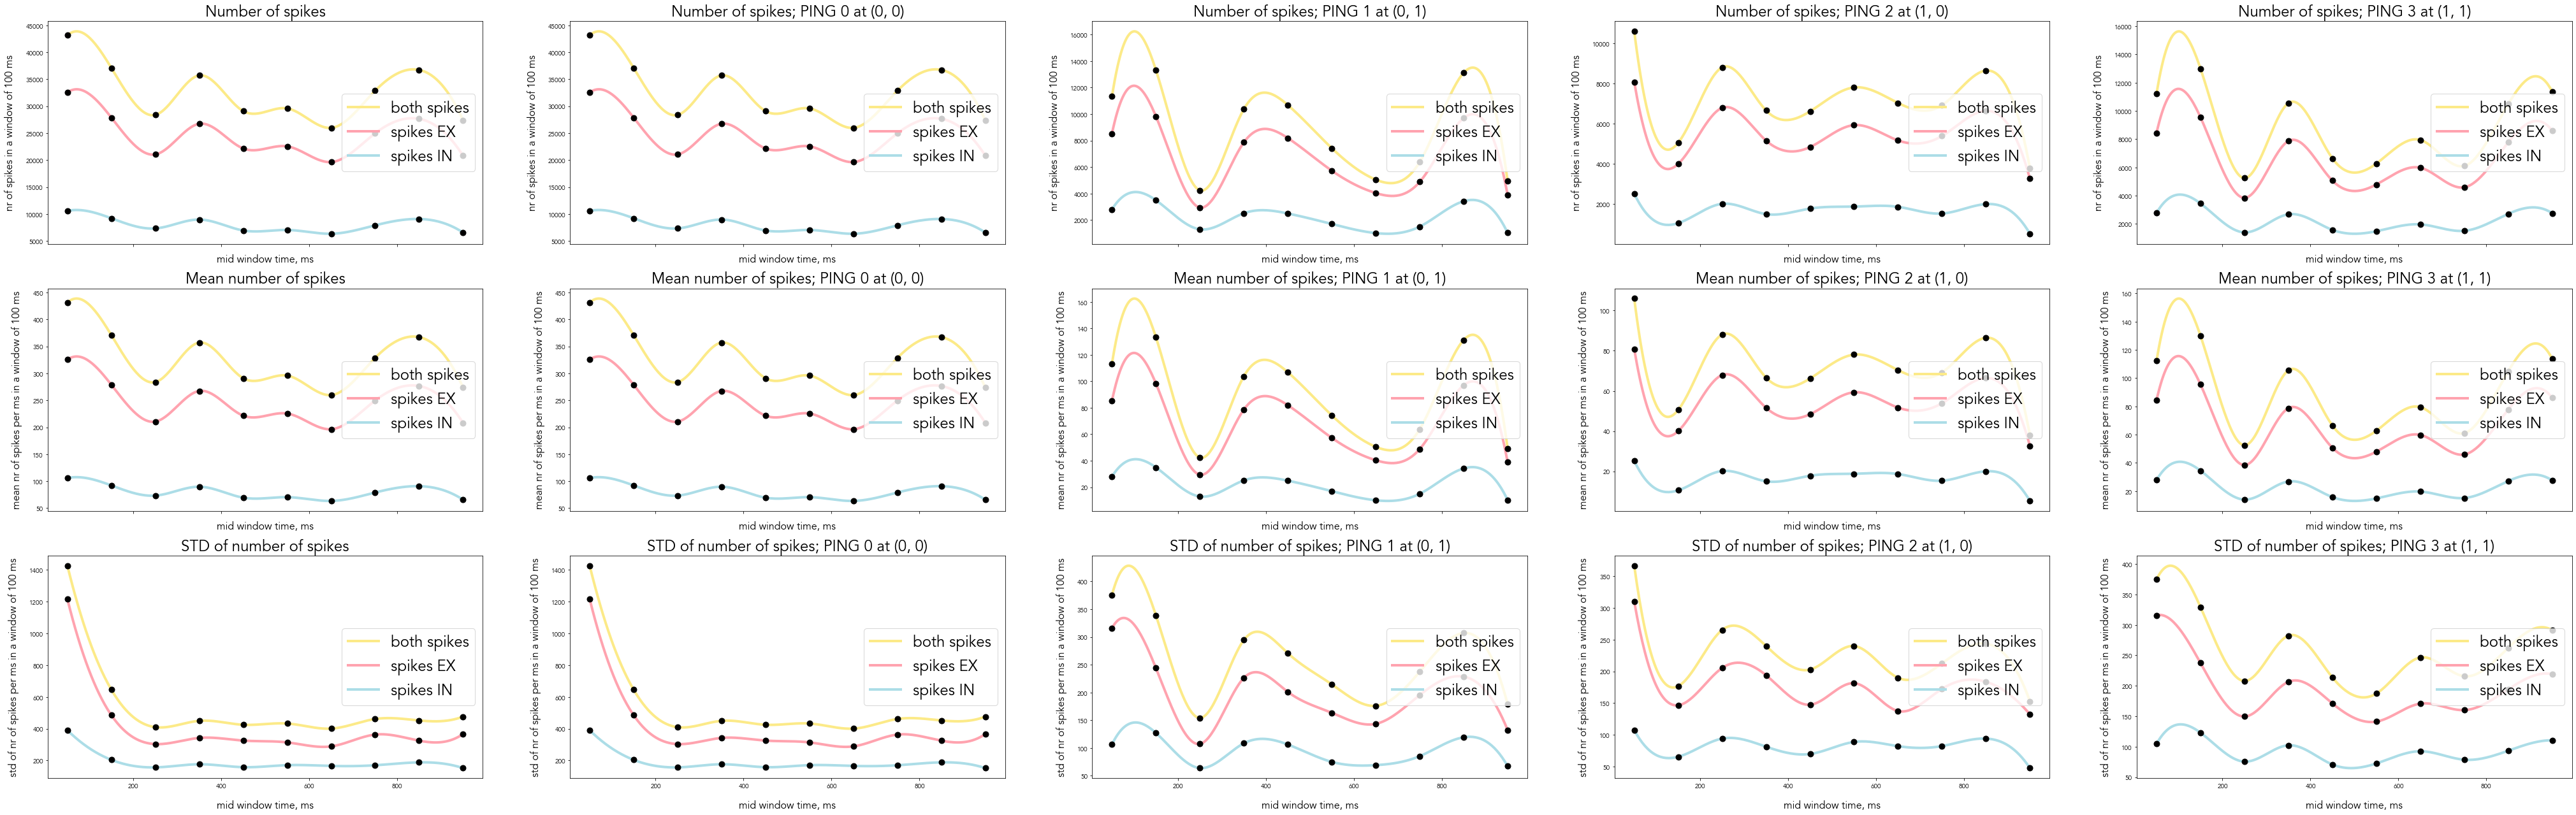

In [22]:
ntypes = 3
fig, ax = plt.subplots(nrows=ntypes, ncols=1+len(ping_networks), sharex=True, figsize=((1+len(ping_networks)) * PLOT_SIZE, ntypes * PLOT_SIZE * 0.5))
plt.subplots_adjust(top=1.5, right=1.5)

in_color = "#ACDDE7"
ex_color = "#FFA3AF"
none_color = "#FCEA88"


mid_windows = [w[0] + (w[1] - w[0]) / 2 for w in windows]
int_x = np.linspace(mid_windows[0], mid_windows[-1], num=300, endpoint = True)
def int_y(arr):
    return scipy.interpolate.make_interp_spline(mid_windows, arr)(int_x)

def plot_spikes(axis, spikes, spikes_ex, spikes_in, title="", ytitle="", ping_id=None, ping_location=None):
    axis.plot(int_x, int_y(spikes), c=none_color, label="both spikes", zorder=0)
    axis.scatter(mid_windows, spikes, s=10*PLOT_SIZE, c="black", zorder=1)
    axis.plot(int_x, int_y(spikes_ex), c=ex_color, label="spikes EX", zorder=0)
    axis.scatter(mid_windows, spikes_ex, s=10*PLOT_SIZE, c="black", zorder=1)
    axis.plot(int_x, int_y(spikes_in), c=in_color, label="spikes IN", zorder=0)
    axis.scatter(mid_windows, spikes_in, s=10*PLOT_SIZE, c="black", zorder=1)
    axis.legend(loc="center right")
    axis.set_xlabel("mid window time, ms")
    axis.set_ylabel(ytitle)
    if not ping_id and not ping_location:
        axis.set_title(title)
    else:
        axis.set_title(f"{title}; PING {ping_id} at {ping_location}")

nr_spikes_title = "Number of spikes"
nr_spikes_ytitle = f"nr of spikes in a window of {step} ms"
mean_spikes_title = "Mean number of spikes"
mean_spikes_ytitle = f"mean nr of spikes per ms in a window of {step} ms"
std_spikes_title = "STD of number of spikes"
std_spikes_ytitle = f"std of nr of spikes per ms in a window of {step} ms"

def draw_col_plots(ax_x, ping_id=None, ping_location=None):
    
    ping_id_str = "" if not ping_id else str(ping_id)
    plot_spikes(
        axis=ax[0][ax_x],
        spikes=spikes_df[f"nr_spikes{ping_id_str}"],
        spikes_ex=spikes_df[f"nr_spikes_ex{ping_id_str}"],
        spikes_in=spikes_df[f"nr_spikes_in{ping_id_str}"],
        title=nr_spikes_title,
        ytitle=nr_spikes_ytitle,
        ping_id=ping_id, 
        ping_location=ping_location
    )

    plot_spikes(
        axis=ax[1][ax_x],
        spikes=spikes_df[f"mean_nr_spikes_per_ts{ping_id_str}"],
        spikes_ex=spikes_df[f"mean_nr_spikes_ex_per_ts{ping_id_str}"],
        spikes_in=spikes_df[f"mean_nr_spikes_in_per_ts{ping_id_str}"],
        title=mean_spikes_title,
        ytitle=mean_spikes_ytitle,
        ping_id=ping_id, 
        ping_location=ping_location
    )

    plot_spikes(
        axis=ax[2][ax_x],
        spikes=spikes_df[f"std_nr_spikes_per_ts{ping_id_str}"],
        spikes_ex=spikes_df[f"std_nr_spikes_ex_per_ts{ping_id_str}"],
        spikes_in=spikes_df[f"std_nr_spikes_in_per_ts{ping_id_str}"],
        title=std_spikes_title,
        ytitle=std_spikes_ytitle,
        ping_id=ping_id, 
        ping_location=ping_location
    )
    

col_count = 0
draw_col_plots(col_count)

for ping_network in ping_networks:
    # TODO:: plot the same stuff for pings
    col_count += 1
    draw_col_plots(col_count, col_count-1, ping_network.grid_location)
    
fig.savefig("stats_per_ping.pdf", bbox_inches='tight', pad_inches=1)

In [23]:
from src.spiking_frequencies.CrossCorrelationFactory import CrossCorrelationFactory

USE_RANDOM_VECTORS = False

if USE_RANDOM_VECTORS:

    import random 
    random_vectors = []
    p = 1.0/24
    for _ in range(1000):
        #random_vectors.append([random.randint(0, 1) for _ in range(1000)])
        random_vectors.append(np.random.binomial(n=1, p=p, size=1000))
        
    phase_values, phase_locking = CrossCorrelationFactory()._compute_cross_correlation(np.array(random_vectors), 1000)
else:
    phase_values, phase_locking = CrossCorrelationFactory().create(all_spikes, params_ping, 1000)

max_lag: 13


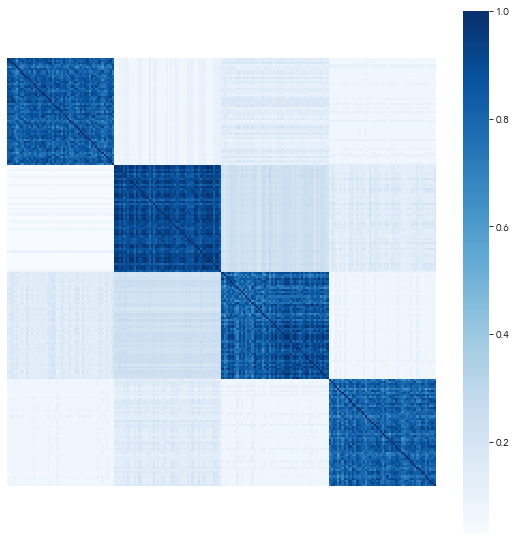

In [24]:
fig, ax = plt.subplots(figsize=(1.2*PLOT_SIZE, 1.2*PLOT_SIZE))

import seaborn as sns

sns.heatmap(
    phase_locking,
    annot=False,
    cbar=True,
    square=True,
    cmap="Blues",
    xticklabels=False,
    yticklabels=False,
    ax=ax
)

fig.savefig("phase_locking.pdf", bbox_inches='tight', pad_inches=1)

In [25]:
# print(min(phase_values.flatten()), max(phase_values.flatten()), np.mean(phase_values.flatten()))
print(min(phase_locking.flatten()), max(phase_locking.flatten()), np.mean(phase_locking.flatten()))

print(
    np.mean([phase_locking[i][j] for i in range(phase_locking.shape[0]) for j in range(phase_locking.shape[1]) if i != j])
)

0.03125 1.0 0.30435336529248613
0.30085765356028765


In [26]:
from src.plotter.raw_data import fetch_cortical_dist_data

distances = fetch_cortical_dist_data()
distances

array([[0.        , 4.25592183, 4.89725344, 7.02371256],
       [4.25592183, 0.        , 2.76906272, 3.33194983],
       [4.89725344, 2.76906272, 0.        , 2.60750402],
       [7.02371256, 3.33194983, 2.60750402, 0.        ]])

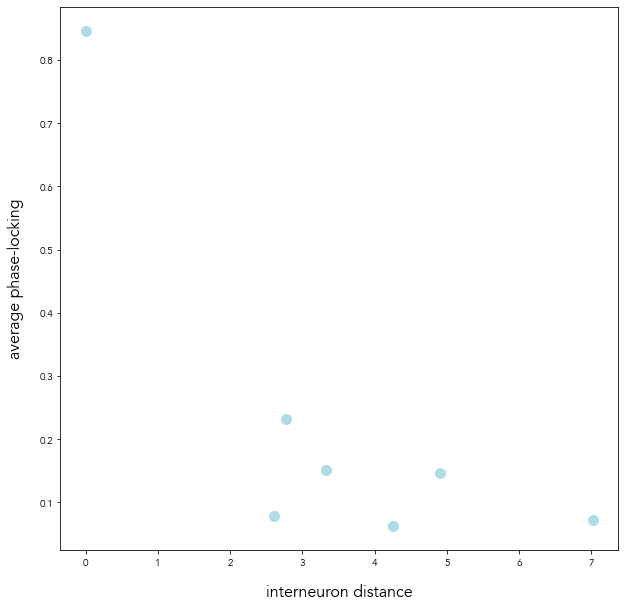

In [27]:
step_size = 10

dist_pl = {}

for i in range(phase_locking.shape[0]):
    for j in range(phase_locking.shape[1]):
        pl = phase_locking[i][j]
        id_i = step_size * i
        id_j = step_size * j
        ping_i = id_i // params_ping.nr_neurons_per_ping[NeuronTypes.IN]
        ping_j = id_j // params_ping.nr_neurons_per_ping[NeuronTypes.IN]
        dist = distances[ping_i][ping_j]
        if dist not in dist_pl:
            dist_pl[dist] = []
        dist_pl[dist].append(pl)

x = []
y = []

for dist in sorted(dist_pl.keys()):
    x.append(dist)
    y.append(np.mean(dist_pl[dist]))

fig, ax = plt.subplots(figsize=(10, 10))  

ax.scatter(x, y, s=100, c=in_color)
ax.set_xlabel("interneuron distance")
ax.set_ylabel("average phase-locking")
fig.savefig("avg_phase_locking.pdf", bbox_inches='tight', pad_inches=1)


In [28]:
# return_to_start_path_from_partic()

<AxesSubplot:>

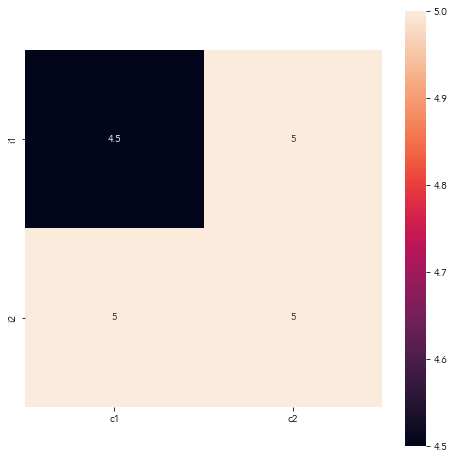

In [37]:
empty_df = pd.DataFrame(index=["i1", "i2"], columns=["c1", "c2"], dtype=float)

empty_df.at["i1", "c1"] = 4.5
empty_df.at["i2", "c2"] = 5
empty_df.at["i1", "c2"] = 5
empty_df.at["i2", "c1"] = 5

empty_df

fig, ax = plt.subplots(figsize=(PLOT_SIZE, PLOT_SIZE))
sns.heatmap(
    empty_df,
    annot=True,
    square=True,
    ax=ax
)

In [41]:
def _format_ic(x):
    return f"{x:.2f}"

_format_ic(5)

'5.00'